# Mosquitoe Breed Classification

In this notebook, we attempt to classify some famous mosquitoe breeds that cause vector-borne diseases like Malaria, Dengue, Zika etc.

The end-user can then, perhaps take a picture of a mosquitoe at his/her home and see what it is and what the diseases it can spread are, and take necessary precautions.

## Setup

Import the FastAI library

In [1]:
from fastai.vision import *
from fastai.metrics import error_rate

Define various _hyperparameters_

In [2]:
bs = 8 # Batch size (decrease if out of memory)
sz = 224 # Image size (increase if using a bigger model)

In [3]:
jtplot_style()

Get the data

In [ ]:
path_img = Path('~/.data/mosquitoes/images').expanduser()

In [ ]:
data = ImageDataBunch.from_folder(path_img, size=sz, bs=bs).normalize(imagenet_stats)

Visualize

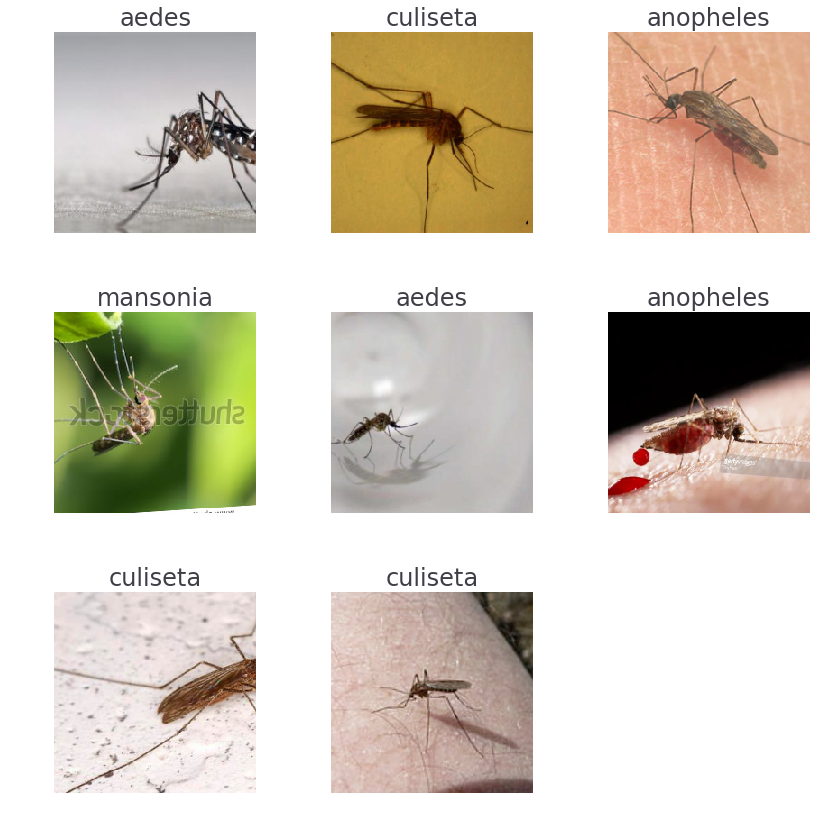

In [6]:
data.show_batch(3)

In [7]:
print(data.classes, data.c)

['aedes', 'anopheles', 'culex', 'culiseta', 'mansonia'] 5


## Train

Create a ResNet18 model

In [8]:
learn = create_cnn(data, models.resnet18, metrics=error_rate)

In [ ]:
learn.fit_one_cycle(2)

Good!

Training for 6 cycles gets us to about {{f'{100 - learn.recorder.metrics[-1][0].item() * 100:.0f}'}}% accuracy. Although that's terrible in today's Deep Learning climate. Also, we can't tolerate this error for such a high-impact task.

In [ ]:
learn.save('stage1') # Save our progress

### Results

Let's interpret our model and see what went wrong.

In [ ]:
interp = ClassificationInterpretation.from_learner(learn)

In [ ]:
interp.plot_top_losses(9, figsize=(24, 24))

The above images are the most wrong.
Some of them are clearly hard to make out.

In [ ]:
interp.plot_confusion_matrix()

In [ ]:
interp.most_confused()

### Unfreezing

Our learner (CNN) is a network consisting of many layers, each more abstract than the previous.

We just happened to _fine-tune_ the final layers above.

In order to go further, we must _unfreeze_ the previous layers and train them together.

In [10]:
learn.unfreeze()

In [ ]:
learn.fit_one_cycle(1)

Not much of an improvement. Let's load back our _weights_.

In [ ]:
learn.load('stage1')

Turns out, the whole model was trained on a dataset called ImageNet which contains a million natural images spanning a thousand categories over many hours.

As a result, these previous layers learned basics like edges and lines and then go up to shapes like circles and corners and then progressively get more complicated (like mosquitoe tails).

Clearly, we don't need to change the initial layers too much since our images are natural as well (our images contain circles and corners too).

And so we need to vary the _learning rate_ (the speed at which we train) _differentially_ between the layers.

The `fit_one_cycle()` method comes with an `lr` parameter to which we can pass a `slice` object to do just this.

<hr>

But, gee, how much speed do we train at.

Lucky for us, the FastAI library includes an `lr_find()` method that finds this for us.

We see that we are bottoming out at $10^{-3}$ and our loss is increasing rapidly thereafter.

As the name suggests, `fit_one_cycle()` is going to cyclically change the learning rate.
What we pass in going to be the minimum lr. This means that we should pick something like $5\times10^{-3}$ for our final layers and $5\times10^{-5}$ for our initial ones.

In [ ]:
learn.fit_one_cycle(2, max_lr=slice(1e-5, 1e-3))

Gosh! Our learner is _overfitting_ terribly!

That is to say, it's doing much better on the training set (lower `train_loss`) than the validation set (`valid_loss`). It's doing pretty bad on images it didn't see before.

The way to overcome this, hopefully is *data_augmentation* where we randomly jitter, flip, zoom, shear and rotate the images to create new artificial data.

## Augmentation

In [ ]:
data = ImageDataBunch.from_folder(path_img, size=sz, bs=bs,
                                  ds_tfms=get_transforms()).normalize(imagenet_stats)

In [ ]:
data.show_batch(3)

In [ ]:
learn = create_cnn(data, models.resnet18, metrics=error_rate)

In [9]:
for _ in range(3): learn.fit_one_cycle(2)

epoch,train_loss,valid_loss,error_rate
1,1.656622,1.381481,0.522727
2,1.308771,1.174810,0.443182


epoch,train_loss,valid_loss,error_rate
1,1.221322,1.044530,0.397727
2,1.171350,1.043858,0.386364


epoch,train_loss,valid_loss,error_rate
1,1.170205,1.079081,0.352273
2,1.116065,1.019531,0.363636


In [ ]:
learn.save('stage1')

In [ ]:
model.unfreeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


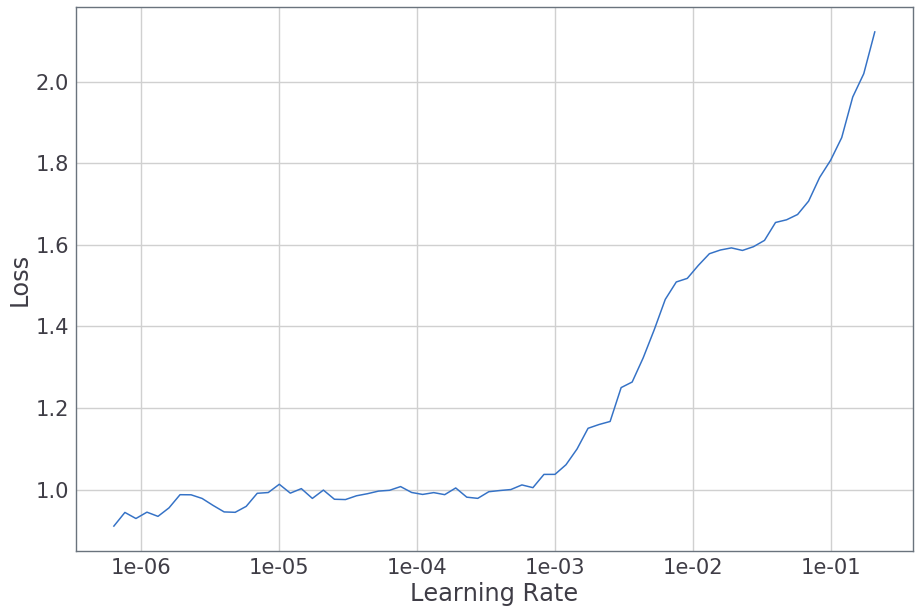

In [11]:
learn.lr_find()
learn.recorder.plot()

In [15]:
for _ in range(4): learn.fit_one_cycle(3, max_lr=slice(1e-6, 1e-4))

epoch,train_loss,valid_loss,error_rate
1,0.825425,0.955097,0.363636
2,0.809928,0.949027,0.329545
3,0.787636,0.949001,0.284091


In [23]:
learn.save('stage2')

### Results

In [16]:
interp = ClassificationInterpretation.from_learner(learn)

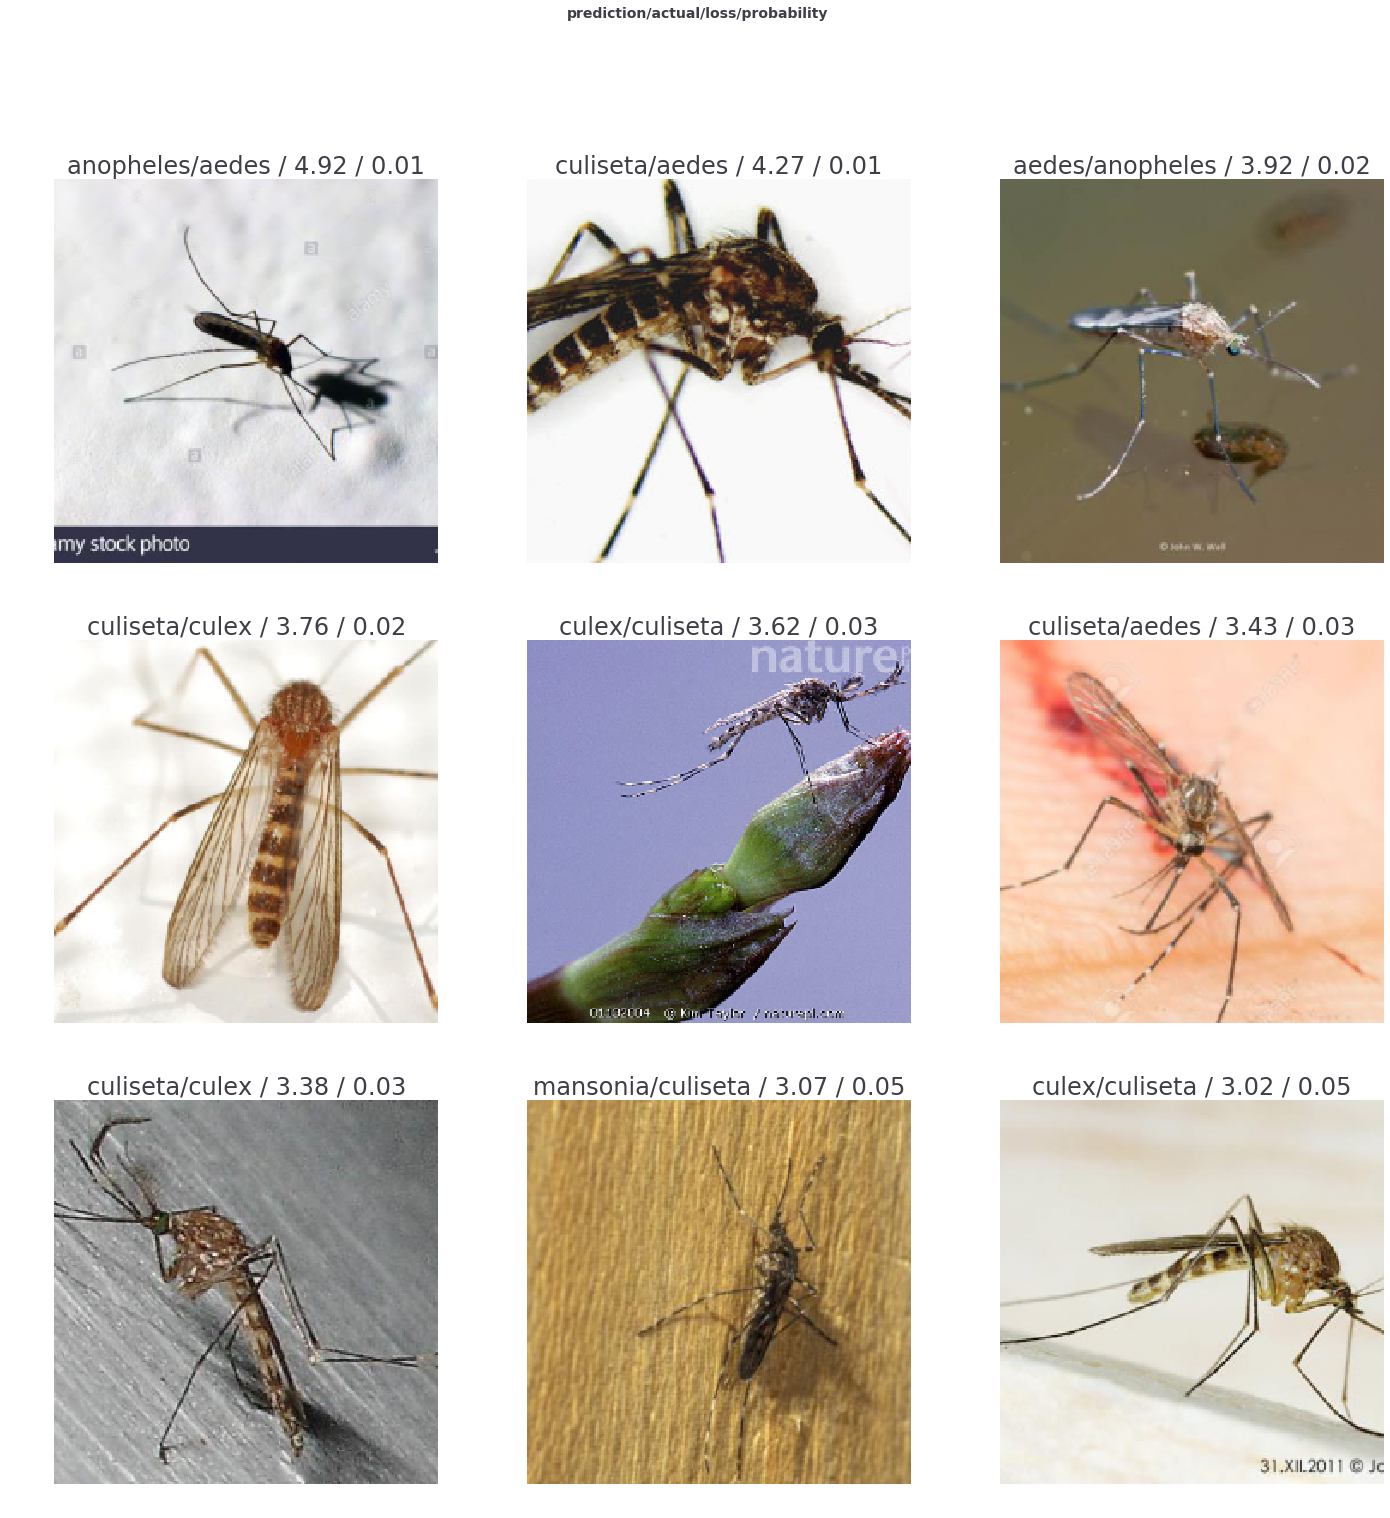

In [17]:
interp.plot_top_losses(9, figsize=(24, 24))

Looking at the picture above, it seems that many of the wrong predictions might be because of unnatural backgrounds.

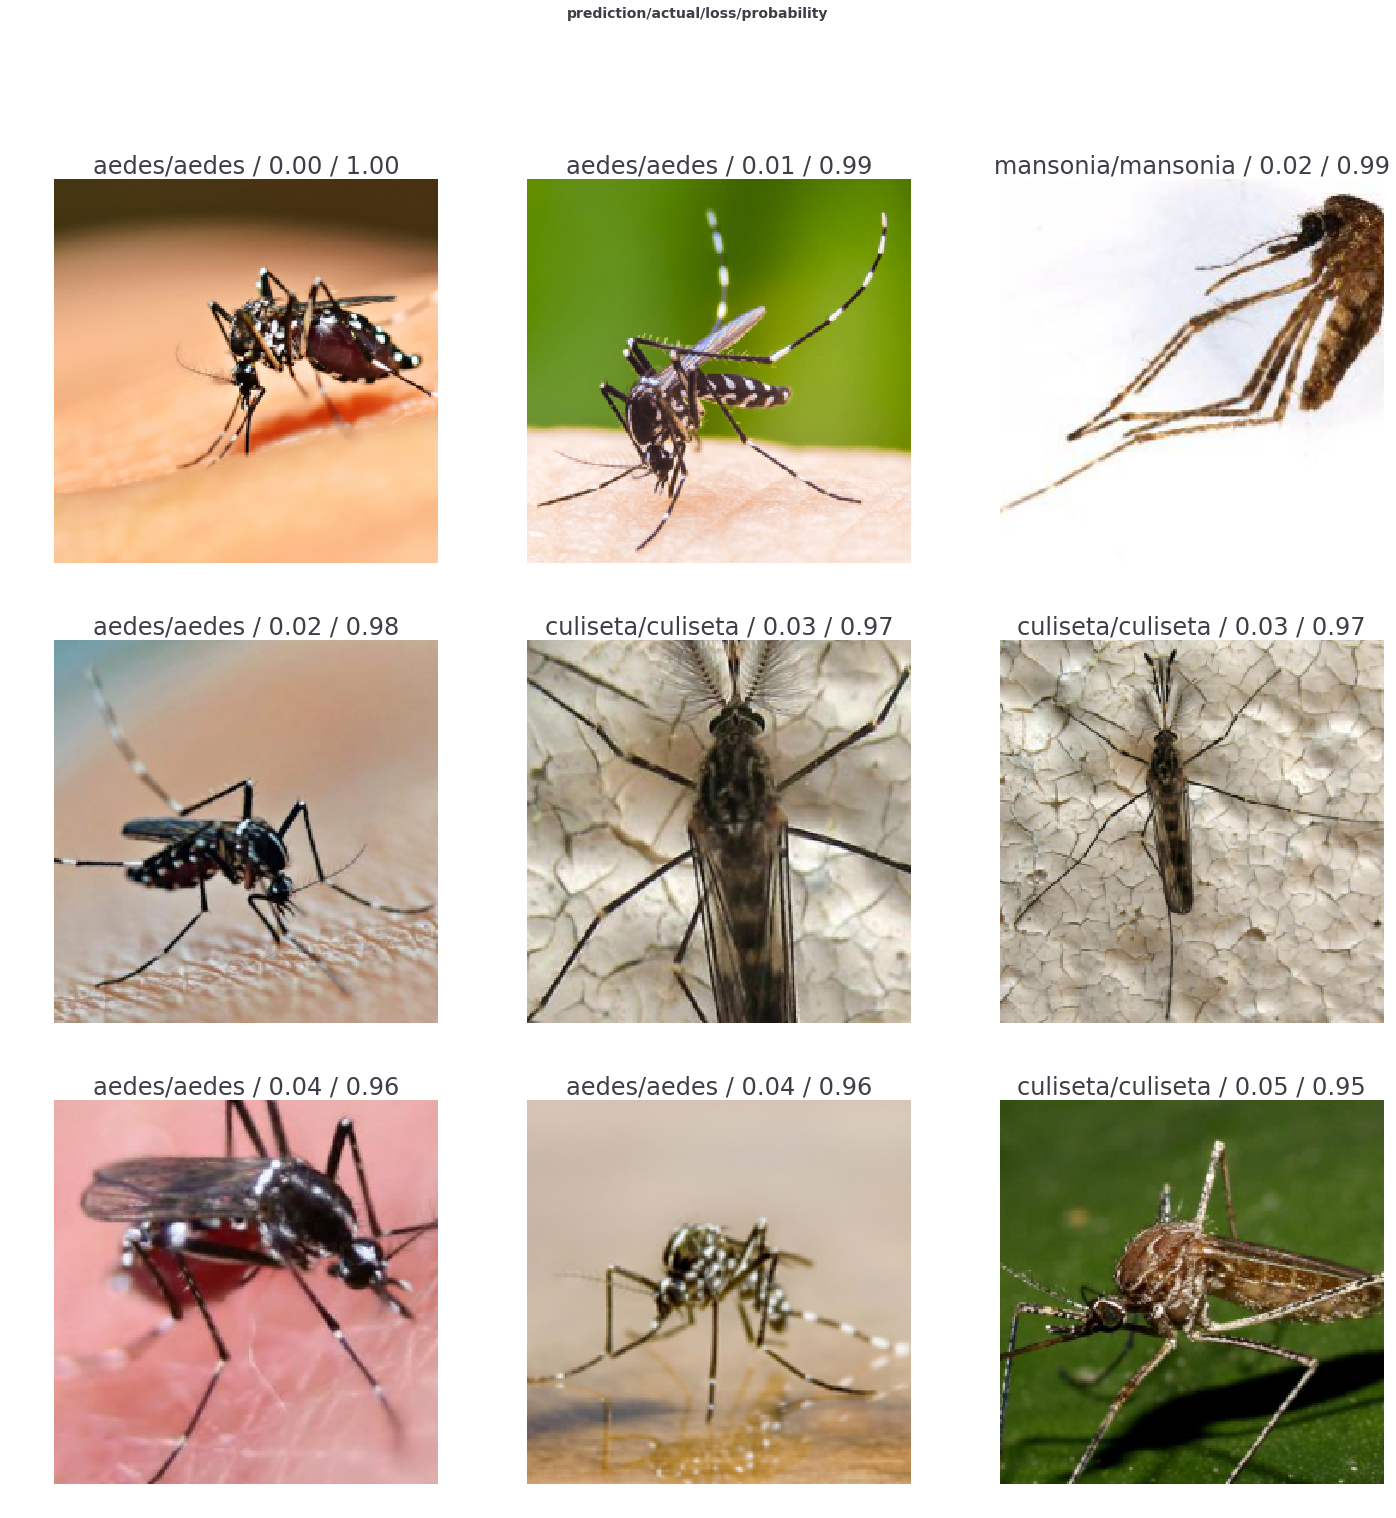

In [18]:
interp.plot_top_losses(9, largest=False, figsize=(24, 24))

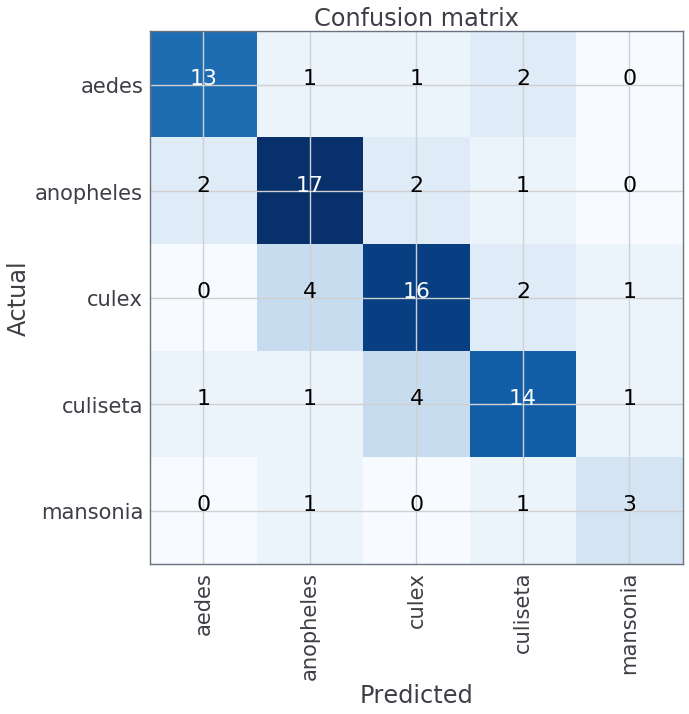

In [22]:
interp.plot_confusion_matrix()

In [20]:
interp.most_confused()

[('culex', 'anopheles', 4),
 ('culiseta', 'culex', 4),
 ('aedes', 'culiseta', 2),
 ('anopheles', 'aedes', 2),
 ('anopheles', 'culex', 2),
 ('culex', 'culiseta', 2)]